In [32]:
import jax.numpy as np
import tree_math
import dataclasses

from jaxsnn.base import funcutils
from jaxsnn.base import implicit
from jaxsnn.tree_solver import ArrayLike, tree_solve, tree_matmul


In [33]:
@tree_math.struct
class NeuronState:
    v: ArrayLike
    I: ArrayLike

@dataclasses.dataclass
class MultiCompartmentNeuronModel(implicit.ImplicitExplicitODE):
  d : ArrayLike
  u : ArrayLike
  p : ArrayLike

  def explicit_terms(self, state):
    return NeuronState(
      v = state.I,
      I = -20*state.I
    )

  def implicit_terms(self, state):
    return NeuronState(
      v = tree_matmul(self.d, self.u, self.p, state.v),
      I = np.zeros_like(state.I)
    )

  def implicit_solve(self, state, step_size):
    return NeuronState(
      v = tree_solve(1 - step_size * self.d, -step_size * self.u, self.p, state.v),
      I = state.I
    )

In [34]:
N = 20
dt = 1e-2
inner_steps = 1
outer_steps = 2000
time = dt * inner_steps * (1 + np.arange(outer_steps))


equation = MultiCompartmentNeuronModel(
    d = -2*np.ones(N),
    u = np.ones(N-1),
    p = np.arange(-1,N,1)
)

initial_state = NeuronState(
    v = np.zeros(N),
    I = np.concatenate((np.array([1.0, 0.0, 0.0, 0.0]), np.zeros(N-4)))
)

semi_implicit_step = implicit.imex_rk_sil3(equation, dt)
integrator = funcutils.trajectory(
            funcutils.repeated(semi_implicit_step, inner_steps), outer_steps)
_, actual = integrator(initial_state)

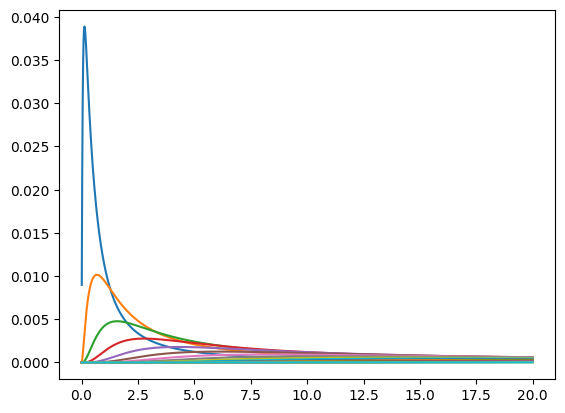

In [35]:
import matplotlib.pyplot as plt

plt.plot(time, actual.v)
plt.show()

In [36]:
a = np.array([
  [0,0,0,0,0,0,0,0],
  [1,0,0,0,0,0,0,0],
  [0,1,0,0,0,0,0,0],
  [0,0,1,0,0,0,0,0],
  [0,0,1,0,0,0,0,0],
  [0,1,0,0,0,0,0,0],
  [0,0,0,0,0,1,0,0],
  [0,0,0,0,0,1,0,0],
])
b = np.arange(1,9)

parents = np.matmul(a, b)

In [37]:
np.diag(np.sum(a + a.T, axis=0)) - (a + a.T)

DeviceArray([[ 1, -1,  0,  0,  0,  0,  0,  0],
             [-1,  3, -1,  0,  0, -1,  0,  0],
             [ 0, -1,  3, -1, -1,  0,  0,  0],
             [ 0,  0, -1,  1,  0,  0,  0,  0],
             [ 0,  0, -1,  0,  1,  0,  0,  0],
             [ 0, -1,  0,  0,  0,  3, -1, -1],
             [ 0,  0,  0,  0,  0, -1,  1,  0],
             [ 0,  0,  0,  0,  0, -1,  0,  1]], dtype=int32)

In [39]:
@dataclasses.dataclass
class MultiCompartmentNeuronModel(implicit.ImplicitExplicitODE):
  m : ArrayLike 

  def explicit_terms(self, state):
    return NeuronState(
      v = state.I,
      I = -20*state.I
    )

  def implicit_terms(self, state):
    return NeuronState(
      v = np.matmul(self.m, state.v),
      I = np.zeros_like(state.I)
    )

  def implicit_solve(self, state, step_size):
    return NeuronState(
      v = tree_solve(1 - step_size * self.d, -step_size * self.u, self.p, state.v),
      I = state.I
    )

In [40]:
def coupling_matrix(G_m, D_s, G_a, A, D_i):
    """"
    Parameters:
        G_m: membrane conductance
        G_a: axial conductance
        D_s: diagonal matrix of compartment surfaces
        D_i: diagonal matrix of inverse volumes
        A  : adjacency matrix
    """
    m = np.matmul(A, D_i) + np.matmul(D_i, A.T)
    M = G_a * (np.diag(np.sum(m)) - m) + G_m * D_s
    return M

Instead of involving the geometry of the neuron (such as the surface and inverse volumes) we can instead use abstract conductances. This simplifies the implementation of the coupling matrix to

In [41]:
def coupling_matrix(G, G_m):
    """"
    Parameters:
        G   : coupling conductances
        G_m : membrane coupling conductances (typically dynamic)
    """
    m = G + G.T
    laplace = np.diag(np.sum(m, axis=0)) - m
    return laplace + np.diag(G_m)

Synaptic transmission gating function (Hu, Senjowski)
$$
\begin{align}
\dot{s} &= \tau^{-1} (- s  + g_\epsilon(v) \dot{v}) \\
\dot{v} &= f(v, I) \\ 
I       &= W s + \ldots
\end{align}
$$
If the resolution of the multicompartment neuron is chosen high enough, the synaptic coupling matrix $W$ will have at most one non-zero entry per column, which indicates which pre-synaptic neuron compartment is connected to which post-synaptic neuron compartment. The overall matrix multiplication is fully implemented by the physical structure of the neuron.




In [42]:
from typing import Callable

@tree_math.struct
class NeuronState:
    v: ArrayLike
    s: ArrayLike # synaptic gating

@dataclasses.dataclass
class MultiCompartmentNeuronModel(implicit.ImplicitExplicitODE):
  # conductance based coupling within neuron
  m : ArrayLike 
  # coupling between neurons
  w : ArrayLike

  # synapse gating mechanism
  tau_s_inv : ArrayLike
  gating_function : Callable

  def explicit_terms(self, state):
    I_s = np.matmul(self.w, state.s)
    I_c = np.matmul(self.m, state.v)
    v_dot = I_s + I_c
    return NeuronState(
      v = I_s,
      s = self.tau_s_inv * (-state.s + self.gating_function(state.v) * v_dot)
    )

  def implicit_terms(self, state):
    return NeuronState(
      v = np.matmul(self.m, state.v),
      s = np.zeros_like(state.s)
    )

  def implicit_solve(self, state, step_size):
    N = state.v.shape[0]
    return NeuronState(
      v = np.linalg.solve(np.eye(N) - step_size * self.m, state.v),
      s = state.s
    )

# A simple neuron model

We consider first a multi-compartment model of adaptive exponential integrate and fire neurons.
They are described by a hybrid dynamical system of the following form:

$$
\begin{align}
C_m \dot{V} &= g_r(t) (V_r - V) + g_l (V_l - V) + g_\mathrm{exp} \Delta_\mathrm{exp} \exp\left(\frac{V - V_\mathrm{exp}}{\Delta_\mathrm{exp} }\right) + I_\mathrm{syn} + I_\mathrm{MC} - w \\
\tau_w \dot{w} &= -a (V_l - V) - w \\
\tau_\mathrm{ref} \dot{r} &= -\Theta(r)
\end{align}
$$
If the neuron compartment reaches a threshold voltage $V_\mathrm{th}$ it is connected to a reset conductance $g_r$ this is modelled by a time dependent conductance $g_r(t)$, which is non-zero during the refractory time, the refractory state variable $r$ jumps by $1$ at the threshold crossing.

In [43]:
@tree_math.struct
class AdexParameters:
    g_l : ArrayLike
    g_exp : ArrayLike
    Delta_exp : ArrayLike
    tau_w_inv : ArrayLike
    a : ArrayLike
    V_l : ArrayLike
    V_exp : ArrayLike
    C_m_inv : ArrayLike
    tau_syn_inv : ArrayLike

@tree_math.struct
class AdexState:
    v : ArrayLike
    w : ArrayLike
    I : ArrayLike

def adex_dynamics(s : AdexState, p: AdexParameters):
    return AdexState(
        v = (p.g_l * p.C_m_inv) * (p.V_l - s.v) + (p.g_exp * p.C_m_inv) * p.Delta_exp * np.exp(1/p.Delta_exp * (s.v - p.V_exp)) - p.C_m_inv * s.w,
        w = -p.a * p.tau_w_inv * (p.V_l - s.v) - p.tau_w_inv * s.w,
        I = 0 # -p.tau_syn_inv * s.I
    )